In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from skimage import io
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('dataset_train.csv')
image_dir = "Homework5_dataset/"
train, valid = train_test_split(df, test_size = 0.20, random_state = 42)
import torch
from PIL import Image
from torchvision import transforms

data_dir = "Homework5_dataset/"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(file_path):
    img = Image.open(data_dir + file_path).convert('RGB')
    img_tensor = transform(img)
    return img_tensor

def load_triplet(row):
    anchor_img = load_image(row.Anchor)
    positive_img = load_image(row.Positive)
    negative_img = load_image(row.Negative)

    return anchor_img, positive_img, negative_img

train_triplets = [load_triplet(row) for _, row in train.iterrows()]
valid_triplets = [load_triplet(row) for _, row in valid.iterrows()]
train_loader = DataLoader(train_triplets, batch_size = 32,shuffle = True)
valid_loader = DataLoader(valid_triplets, batch_size = 32)


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
# Model Definition
class TripModel(nn.Module):
    def __init__(self, emb_size=512):
        super(TripModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[-1].in_features
        self.efficientnet.classifier[-1] = nn.Linear(in_features, emb_size)
    
    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings
    
model = TripModel()
model.to("cuda:1") 
print("Model Loaded")

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Loaded


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomTripletMarginLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(CustomTripletMarginLoss, self).__init__()
        self.margin = margin

    def euclidean_distance(self, x1, x2):
        return torch.sqrt(torch.sum((x1 - x2) ** 2, dim=1))

    def forward(self, anchor, positive, negative):
        distance_positive = self.euclidean_distance(anchor, positive)
        distance_negative = self.euclidean_distance(anchor, negative)

        loss = torch.clamp(distance_positive - distance_negative + self.margin, min=0.0).mean()

        return loss


# margin= 0.1

In [4]:
criterion = CustomTripletMarginLoss(margin=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [5]:
import torch
from tqdm import tqdm
import numpy as np

device = "cuda:1" if torch.cuda.is_available() else "cpu"
model.to(device)
best_valid_loss = np.Inf

train_losses = []
valid_losses = []

for epoch in range(20):
    # Training
    model.train()
    total_train_loss = 0.0
    
    for A, P, N in tqdm(train_loader):
        A, P, N = A.to(device), P.to(device), N.to(device)
        
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        
        loss = criterion(A_embs, P_embs, N_embs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    
    # Validation
    model.eval()
    total_valid_loss = 0.0
    
    with torch.no_grad():
        for A, P, N in tqdm(valid_loader):
            A, P, N = A.to(device), P.to(device), N.to(device)
            
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)
            
            loss = criterion(A_embs, P_embs, N_embs)
            
            total_valid_loss += loss.item()
    
    valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    
    # Check if validation loss improved and save the model
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model_triplet_0_1.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHT_SUCCESS")
    
    print(f"EPOCHS: {epoch+1} train_loss: {train_loss} valid_loss: {valid_loss}")


100%|██████████| 25/25 [00:01<00:00, 19.67it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 1 train_loss: 0.13080440096557142 valid_loss: 0.07196094495244325


100%|██████████| 25/25 [00:01<00:00, 21.18it/s]


EPOCHS: 2 train_loss: 0.0711875178408809 valid_loss: 0.12577274050563575


100%|██████████| 25/25 [00:01<00:00, 17.91it/s]


EPOCHS: 3 train_loss: 0.04981812935555354 valid_loss: 0.08846249640919268


100%|██████████| 25/25 [00:01<00:00, 15.96it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 4 train_loss: 0.07196204751962795 valid_loss: 0.043622126514092086


100%|██████████| 25/25 [00:01<00:00, 16.88it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 5 train_loss: 0.03000391827430576 valid_loss: 0.03874760379083455


100%|██████████| 25/25 [00:01<00:00, 19.60it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 6 train_loss: 0.02303234190447256 valid_loss: 0.03286537335254252


100%|██████████| 25/25 [00:01<00:00, 21.00it/s]


EPOCHS: 7 train_loss: 0.01814114198088646 valid_loss: 0.03773677816614509


100%|██████████| 25/25 [00:01<00:00, 20.59it/s]


EPOCHS: 8 train_loss: 0.020827235458418726 valid_loss: 0.04723586705513298


100%|██████████| 25/25 [00:01<00:00, 21.21it/s]


EPOCHS: 9 train_loss: 0.02237903291825205 valid_loss: 0.033777149822562934


100%|██████████| 25/25 [00:01<00:00, 19.73it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 10 train_loss: 0.015991743481718005 valid_loss: 0.02312093885615468


100%|██████████| 25/25 [00:01<00:00, 21.11it/s]


EPOCHS: 11 train_loss: 0.013390852718148381 valid_loss: 0.061234656013548376


100%|██████████| 25/25 [00:01<00:00, 18.87it/s]


EPOCHS: 12 train_loss: 0.042305728928186 valid_loss: 0.026135466918349268


100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


EPOCHS: 13 train_loss: 0.021921110968105496 valid_loss: 0.04194428593851626


100%|██████████| 25/25 [00:01<00:00, 23.03it/s]


EPOCHS: 14 train_loss: 0.020717930672690274 valid_loss: 0.058452092576771975


100%|██████████| 25/25 [00:01<00:00, 22.94it/s]


EPOCHS: 15 train_loss: 0.03031696521677077 valid_loss: 0.041748825730755924


100%|██████████| 25/25 [00:01<00:00, 22.76it/s]


EPOCHS: 16 train_loss: 0.025959687829017638 valid_loss: 0.04819417338818312


100%|██████████| 25/25 [00:01<00:00, 22.62it/s]


EPOCHS: 17 train_loss: 0.02635896153980866 valid_loss: 0.0322477806173265


100%|██████████| 25/25 [00:01<00:00, 22.46it/s]


EPOCHS: 18 train_loss: 0.014584311491344124 valid_loss: 0.04264734286814928


100%|██████████| 25/25 [00:01<00:00, 22.72it/s]


EPOCHS: 19 train_loss: 0.01990784113295376 valid_loss: 0.04455947131849825


100%|██████████| 25/25 [00:01<00:00, 21.23it/s]

EPOCHS: 20 train_loss: 0.01641268810722977 valid_loss: 0.031119690779596566


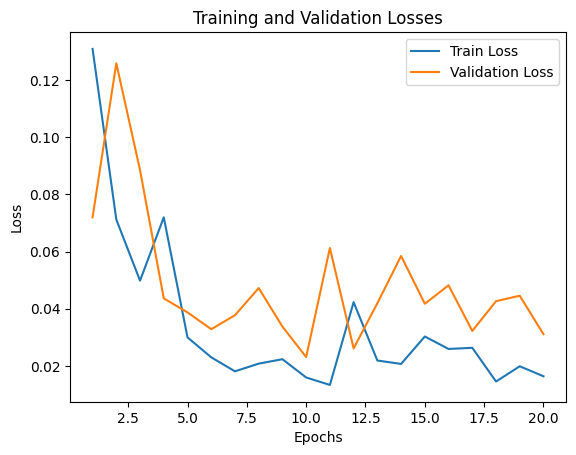

In [6]:
# Plotting
plt.plot(range(1, 21), train_losses, label='Train Loss')
plt.plot(range(1, 21), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [9]:
model.load_state_dict(torch.load("best_model_triplet_0_1.pt"))
print("Model Loaded")

def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist


import numpy as np
import pandas as pd
from skimage import io
import torch
from tqdm import tqdm
from PIL import Image  # Import Image from PIL

data_dir = "Homework5_dataset/"  
df = pd.read_csv("dataset_train.csv")  

anc_img_names = df["Anchor"].tolist()
anc_img_names_arr = np.array(anc_img_names)
encodings = []

model.eval()
with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
        # Using PIL to read the image
        A = Image.open(data_dir + i)
        A = np.array(A)  # Convert PIL image to NumPy array
        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
        A = A.to("cuda:1")
        A_enc = model(A.unsqueeze(0)) 
        encodings.append(A_enc.squeeze().cpu().detach().numpy())

encodings = np.array(encodings)
encodings_df = pd.DataFrame(encodings)
df_enc = pd.concat([pd.Series(anc_img_names, name="Anchor"), encodings_df], axis=1)

df_enc.to_csv("output_0_1.csv", index=False)
import numpy as np
import torch
from skimage import io

def process_image(idx, df_enc, model, data_dir):
    img_name = df_enc["Anchor"].iloc[idx]
    img_path = data_dir + img_name

    img = io.imread(img_path)
    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

    model.eval()
    with torch.no_grad():
        img = img.to("cuda:1")
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()

    anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
    anc_img_names = df_enc["Anchor"]

    distance = []

    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return anc_img_names, data_dir, img, img_path, closest_idx, distance



import networkx as nx 
import matplotlib.pyplot as plt
from PIL import Image  

def load_image(image_path):
    # Use PIL to open the image
    image = Image.open(image_path)
    return image

def create_graph(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest=10):
    G = nx.Graph()

    S_name = [img_path.split('/')[-1]]

    for s in range(no_of_closest):
        S_name.append(anc_img_names.iloc[closest_idx[s]])

    for i, img_name in enumerate(S_name):
        image = load_image(DATA_DIR + img_name)
        G.add_node(i, image=image)

    for j in range(1, no_of_closest + 1):
        G.add_edge(0, j, weight=distance[closest_idx[j - 1]])

    return G, S_name


def plot_graph(G, S_name):
    pos = nx.kamada_kawai_layout(G)

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G, pos, ax=ax)

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    piesize = 0.1  # this is the image size
    p2 = piesize / 2.0
    for n in G:
        xx, yy = trans(pos[n])  # figure coordinates
        xa, ya = trans2((xx, yy))  # axes coordinates
        a = plt.axes([xa - p2, ya - p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.set_title(S_name[n][0:4])
        a.axis('off')

    ax.axis('off')
    plt.show()


def plot_closest_imgs(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest=10):
    G, S_name = create_graph(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest)
    plot_graph(G, S_name)


Model Loaded


100%|██████████| 4000/4000 [00:19<00:00, 200.64it/s]


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


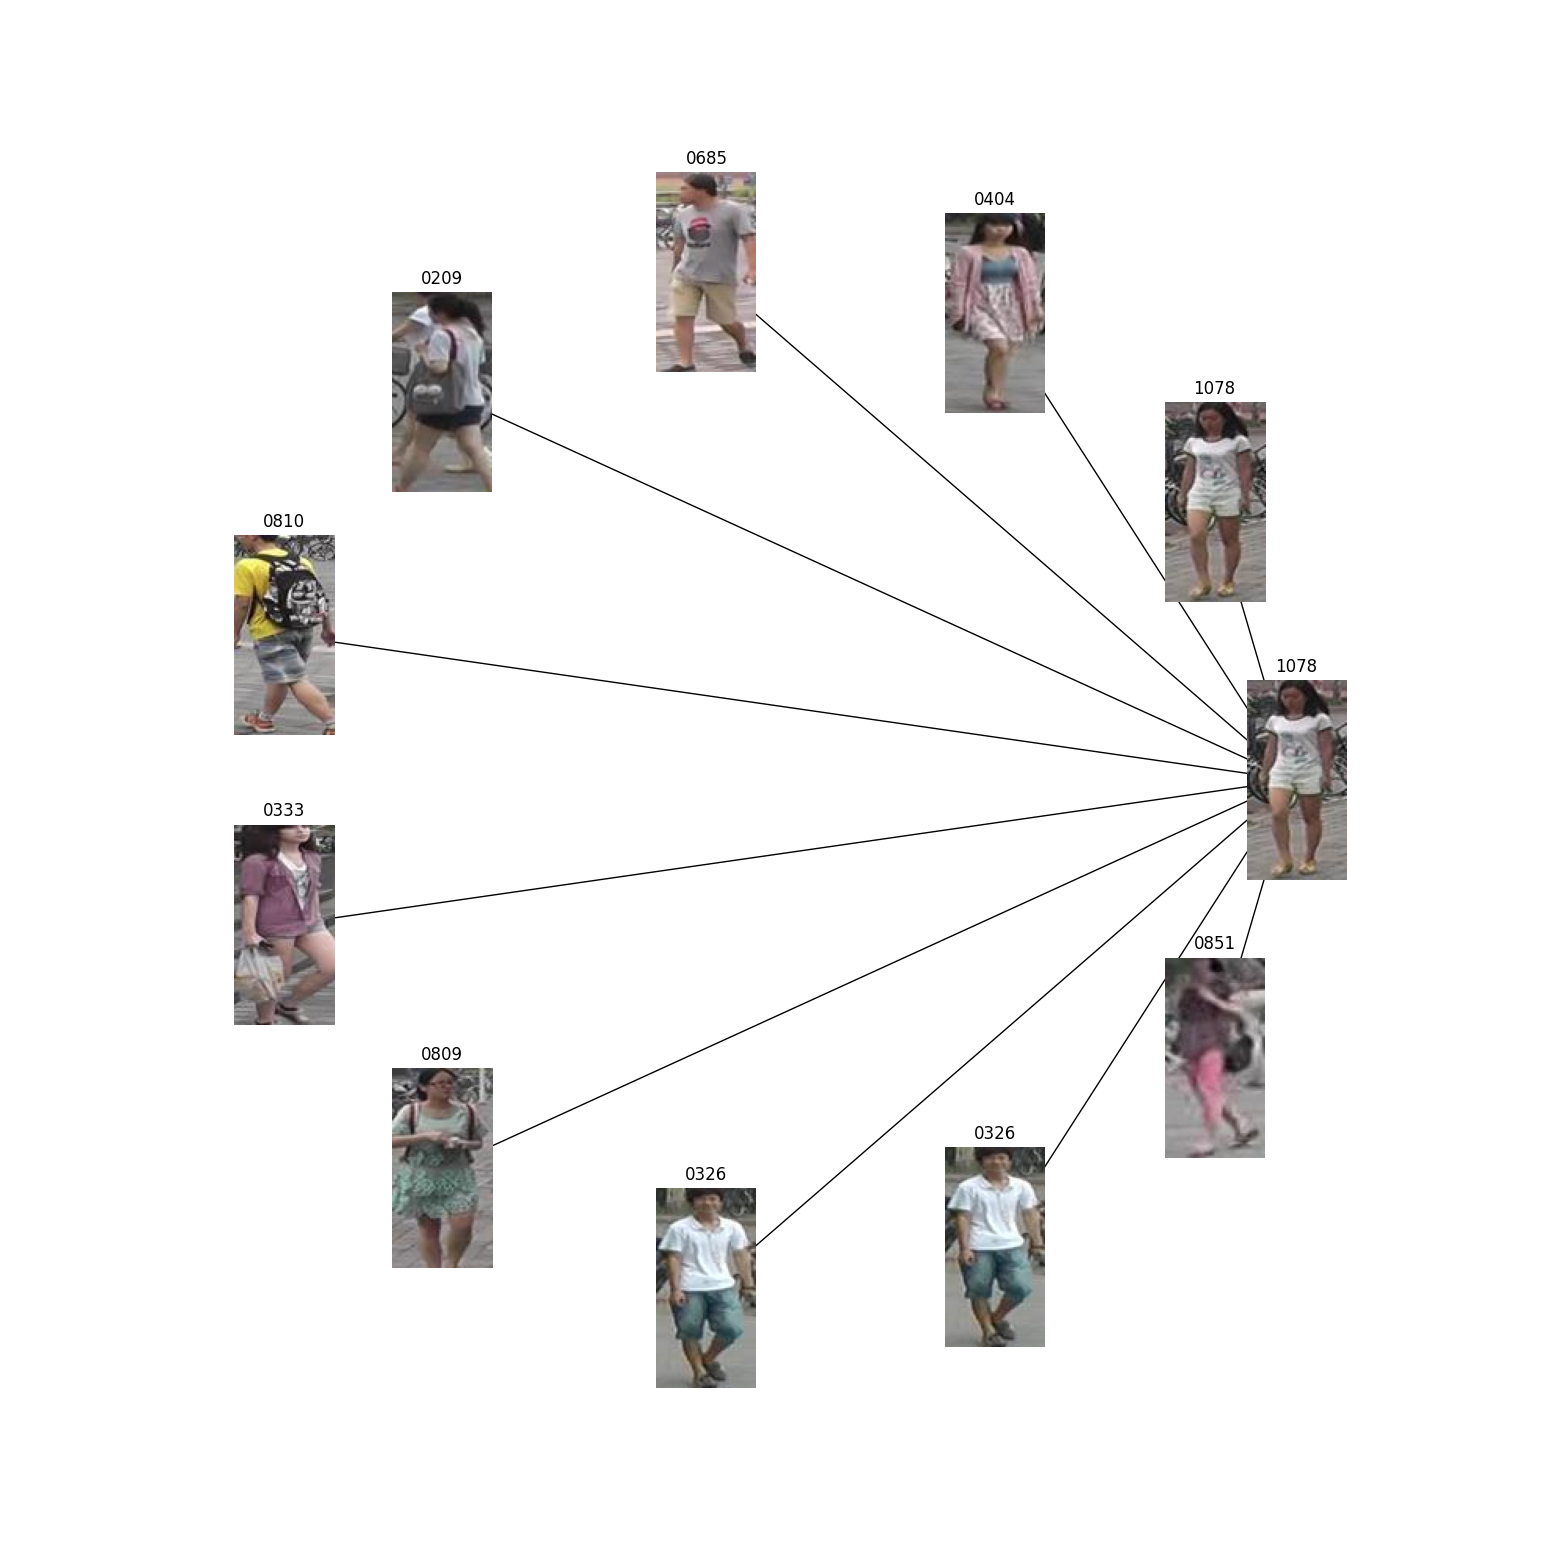

In [10]:
result = process_image(10, df_enc, model, data_dir)
anc_img_names, data_dir, img, img_path, closest_idx, distance = result

plot_closest_imgs(anc_img_names, data_dir, img_path, closest_idx, distance, no_of_closest=10)


In [5]:
model.load_state_dict(torch.load("best_model_triplet_0_1.pt"))
print("Model Loaded")
import torch
from tqdm import tqdm

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Initialize counters for correct and total pairs
correct_pairs = 0
total_pairs = 0

model.eval()

with torch.no_grad():
    for A, P, N in tqdm(valid_loader):
        A, P, N = A.to(device), P.to(device), N.to(device)

        # Forward pass to get embeddings
        emb_A = model(A)
        emb_P = model(P)
        emb_N = model(N)

        # Compute Euclidean distances
        dist_pos = torch.norm(emb_A - emb_P, dim=1)
        dist_neg = torch.norm(emb_A - emb_N, dim=1)

        # Check if the distance of the positive pair is smaller than the distance of the negative pair
        correct_pairs += torch.sum(dist_pos < dist_neg).item()
        total_pairs += A.size(0)  # Batch size

# Calculate similarity accuracy
similarity_accuracy = correct_pairs / total_pairs

print(f"Similarity Accuracy: {similarity_accuracy * 100:.2f}%")


Model Loaded


100%|██████████| 25/25 [00:01<00:00, 17.68it/s]

Similarity Accuracy: 97.12%


# ROC

In [33]:
model.load_state_dict(torch.load("best_model_triplet_0_1.pt"))
print("Model Loaded")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("model loaded")

Model Loaded
model loaded


In [37]:
# Function to calculate similarity scores
def calculate_similarity(embedding1, embedding2):
    # Cosine similarity is a common choice
    return torch.nn.functional.cosine_similarity(embedding1, embedding2).cpu().numpy()


# Prepare data for ROC
similarity_scores = []
true_labels = []

with torch.no_grad():
    for batch in valid_loader:
    # for batch in train_loader:    
        anchor_images, positive_images, negative_images = batch  
        anchor_images, positive_images, negative_images = anchor_images.to(device), positive_images.to(device), negative_images.to(device)

        # Forward pass for anchor-positive pairs
        anchor_embeddings = model(anchor_images)
        positive_embeddings = model(positive_images)
        scores_positive = calculate_similarity(anchor_embeddings, positive_embeddings)
        similarity_scores.extend(scores_positive)
        true_labels.extend([1] * len(scores_positive))  # 1 for similar

        # Forward pass for anchor-negative pairs
        negative_embeddings = model(negative_images)
        scores_negative = calculate_similarity(anchor_embeddings, negative_embeddings)
        similarity_scores.extend(scores_negative)
        true_labels.extend([0] * len(scores_negative))  # 0 for not similar

In [38]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(true_labels, similarity_scores)
roc_auc = auc(fpr, tpr)

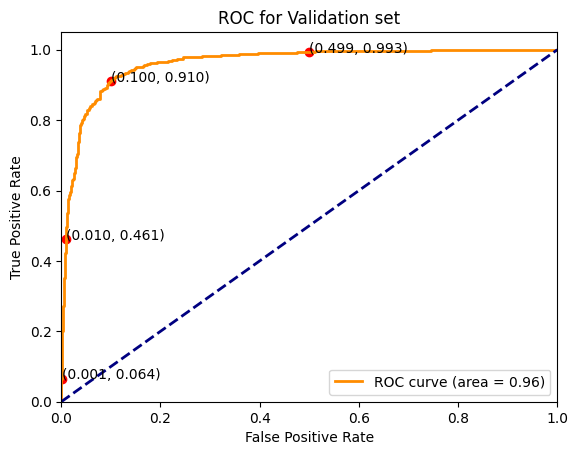

In [39]:
# Function to find closest index in an array to a given value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Desired FPR values
desired_fprs = [0.5, 0.1, 0.01, 0.001]

# Find nearest FPRs and corresponding TPRs
nearest_fprs = [fpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]
nearest_tprs = [tpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate desired points
for fpr_point, tpr_point in zip(nearest_fprs, nearest_tprs):
    plt.scatter(fpr_point, tpr_point, color='red')
    plt.text(fpr_point, tpr_point, f'({fpr_point:.3f}, {tpr_point:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Validation set')
plt.legend(loc="lower right")
plt.show()

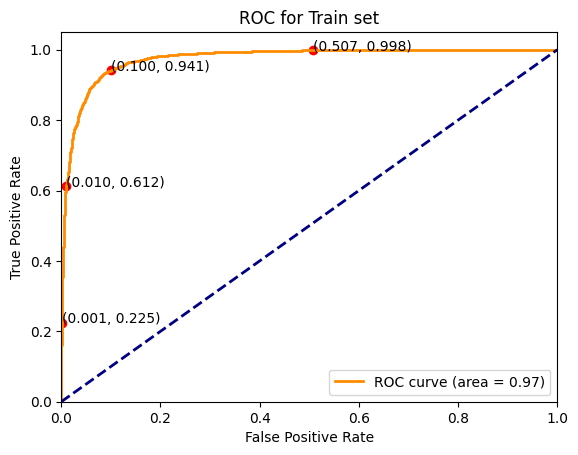

In [36]:
# Function to find closest index in an array to a given value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Desired FPR values
desired_fprs = [0.5, 0.1, 0.01, 0.001]

# Find nearest FPRs and corresponding TPRs
nearest_fprs = [fpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]
nearest_tprs = [tpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate desired points
for fpr_point, tpr_point in zip(nearest_fprs, nearest_tprs):
    plt.scatter(fpr_point, tpr_point, color='red')
    plt.text(fpr_point, tpr_point, f'({fpr_point:.3f}, {tpr_point:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Train set')
plt.legend(loc="lower right")
plt.show()

# margin= 10

In [15]:
criterion = CustomTripletMarginLoss(margin=10)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [16]:
import torch
from tqdm import tqdm
import numpy as np

device = "cuda:1" if torch.cuda.is_available() else "cpu"
best_valid_loss = np.Inf

train_losses = []
valid_losses = []

for epoch in range(20):
    # Training
    model.train()
    total_train_loss = 0.0
    
    for A, P, N in tqdm(train_loader):
        A, P, N = A.to(device), P.to(device), N.to(device)
        
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        
        loss = criterion(A_embs, P_embs, N_embs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    
    # Validation
    model.eval()
    total_valid_loss = 0.0
    
    with torch.no_grad():
        for A, P, N in tqdm(valid_loader):
            A, P, N = A.to(device), P.to(device), N.to(device)
            
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)
            
            loss = criterion(A_embs, P_embs, N_embs)
            
            total_valid_loss += loss.item()
    
    valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    
    # Check if validation loss improved and save the model
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model_triplet_10.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHT_SUCCESS")
    
    print(f"EPOCHS: {epoch+1} train_loss: {train_loss} valid_loss: {valid_loss}")


100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 1 train_loss: 4.712399342060089 valid_loss: 4.1286432790756225


100%|██████████| 25/25 [00:01<00:00, 18.83it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 2 train_loss: 2.019691210389137 valid_loss: 3.1514908933639525


100%|██████████| 25/25 [00:01<00:00, 16.13it/s]


EPOCHS: 3 train_loss: 1.6120570337772369 valid_loss: 3.9281820487976074


100%|██████████| 25/25 [00:01<00:00, 17.27it/s]


EPOCHS: 4 train_loss: 1.3890488296747208 valid_loss: 3.389504714012146


100%|██████████| 25/25 [00:01<00:00, 18.07it/s]


EPOCHS: 5 train_loss: 1.3147302621603012 valid_loss: 3.4031882762908934


100%|██████████| 25/25 [00:01<00:00, 21.11it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 6 train_loss: 1.2464775228500367 valid_loss: 3.0732094430923462


100%|██████████| 25/25 [00:01<00:00, 20.92it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 7 train_loss: 0.9571687263250351 valid_loss: 2.570817413330078


100%|██████████| 25/25 [00:01<00:00, 19.92it/s]


EPOCHS: 8 train_loss: 1.115828688144684 valid_loss: 3.474316945075989


100%|██████████| 25/25 [00:01<00:00, 19.77it/s]


EPOCHS: 9 train_loss: 0.9940396934747696 valid_loss: 3.257910656929016


100%|██████████| 25/25 [00:01<00:00, 19.02it/s]


EPOCHS: 10 train_loss: 0.8953732991218567 valid_loss: 3.5239150094985963


100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


EPOCHS: 11 train_loss: 0.7023099333047866 valid_loss: 3.389952006340027


100%|██████████| 25/25 [00:01<00:00, 16.45it/s]


EPOCHS: 12 train_loss: 0.5661239147186279 valid_loss: 3.661201238632202


100%|██████████| 25/25 [00:01<00:00, 16.09it/s]


EPOCHS: 13 train_loss: 0.6629683518409729 valid_loss: 2.8105299949645994


100%|██████████| 25/25 [00:01<00:00, 20.20it/s]


EPOCHS: 14 train_loss: 0.5611469584703446 valid_loss: 3.715289421081543


100%|██████████| 25/25 [00:01<00:00, 20.10it/s]


EPOCHS: 15 train_loss: 0.5928495019674301 valid_loss: 3.763303165435791


100%|██████████| 25/25 [00:01<00:00, 16.27it/s]


EPOCHS: 16 train_loss: 0.6173432803153992 valid_loss: 3.092164258956909


100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


EPOCHS: 17 train_loss: 0.40824775576591493 valid_loss: 4.189809641838074


100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


EPOCHS: 18 train_loss: 0.5328915965557098 valid_loss: 3.3353010320663454


100%|██████████| 25/25 [00:01<00:00, 16.54it/s]


EPOCHS: 19 train_loss: 0.8321752882003784 valid_loss: 3.055313410758972


100%|██████████| 25/25 [00:01<00:00, 21.00it/s]

EPOCHS: 20 train_loss: 0.38812236666679384 valid_loss: 3.163489956855774


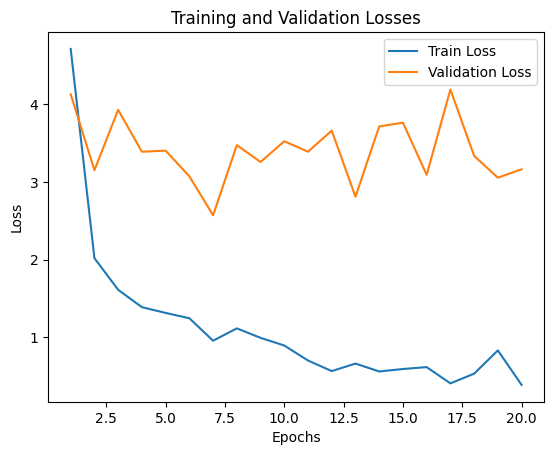

In [17]:
# Plotting
plt.plot(range(1, 21), train_losses, label='Train Loss')
plt.plot(range(1, 21), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [18]:
model.load_state_dict(torch.load("best_model_triplet_10.pt"))
print("Model Loaded")

def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist


import numpy as np
import pandas as pd
from skimage import io
import torch
from tqdm import tqdm
from PIL import Image  # Import Image from PIL

data_dir = "Homework5_dataset/"  
df = pd.read_csv("dataset_train.csv")  

anc_img_names = df["Anchor"].tolist()
anc_img_names_arr = np.array(anc_img_names)
encodings = []

model.eval()
with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
        # Using PIL to read the image
        A = Image.open(data_dir + i)
        A = np.array(A)  # Convert PIL image to NumPy array
        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
        A = A.to("cuda:1")
        A_enc = model(A.unsqueeze(0)) 
        encodings.append(A_enc.squeeze().cpu().detach().numpy())

encodings = np.array(encodings)
encodings_df = pd.DataFrame(encodings)
df_enc = pd.concat([pd.Series(anc_img_names, name="Anchor"), encodings_df], axis=1)

df_enc.to_csv("output_10.csv", index=False)
import numpy as np
import torch
from skimage import io

def process_image(idx, df_enc, model, data_dir):
    img_name = df_enc["Anchor"].iloc[idx]
    img_path = data_dir + img_name

    img = io.imread(img_path)
    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

    model.eval()
    with torch.no_grad():
        img = img.to("cuda:1")
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()

    anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
    anc_img_names = df_enc["Anchor"]

    distance = []

    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return anc_img_names, data_dir, img, img_path, closest_idx, distance



import networkx as nx 
import matplotlib.pyplot as plt
from PIL import Image  

def load_image(image_path):
    # Use PIL to open the image
    image = Image.open(image_path)
    return image

def create_graph(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest=10):
    G = nx.Graph()

    S_name = [img_path.split('/')[-1]]

    for s in range(no_of_closest):
        S_name.append(anc_img_names.iloc[closest_idx[s]])

    for i, img_name in enumerate(S_name):
        image = load_image(DATA_DIR + img_name)
        G.add_node(i, image=image)

    for j in range(1, no_of_closest + 1):
        G.add_edge(0, j, weight=distance[closest_idx[j - 1]])

    return G, S_name


def plot_graph(G, S_name):
    pos = nx.kamada_kawai_layout(G)

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G, pos, ax=ax)

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    piesize = 0.1  # this is the image size
    p2 = piesize / 2.0
    for n in G:
        xx, yy = trans(pos[n])  # figure coordinates
        xa, ya = trans2((xx, yy))  # axes coordinates
        a = plt.axes([xa - p2, ya - p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.set_title(S_name[n][0:4])
        a.axis('off')

    ax.axis('off')
    plt.show()


def plot_closest_imgs(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest=10):
    G, S_name = create_graph(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest)
    plot_graph(G, S_name)


Model Loaded


100%|██████████| 4000/4000 [00:17<00:00, 232.32it/s]


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


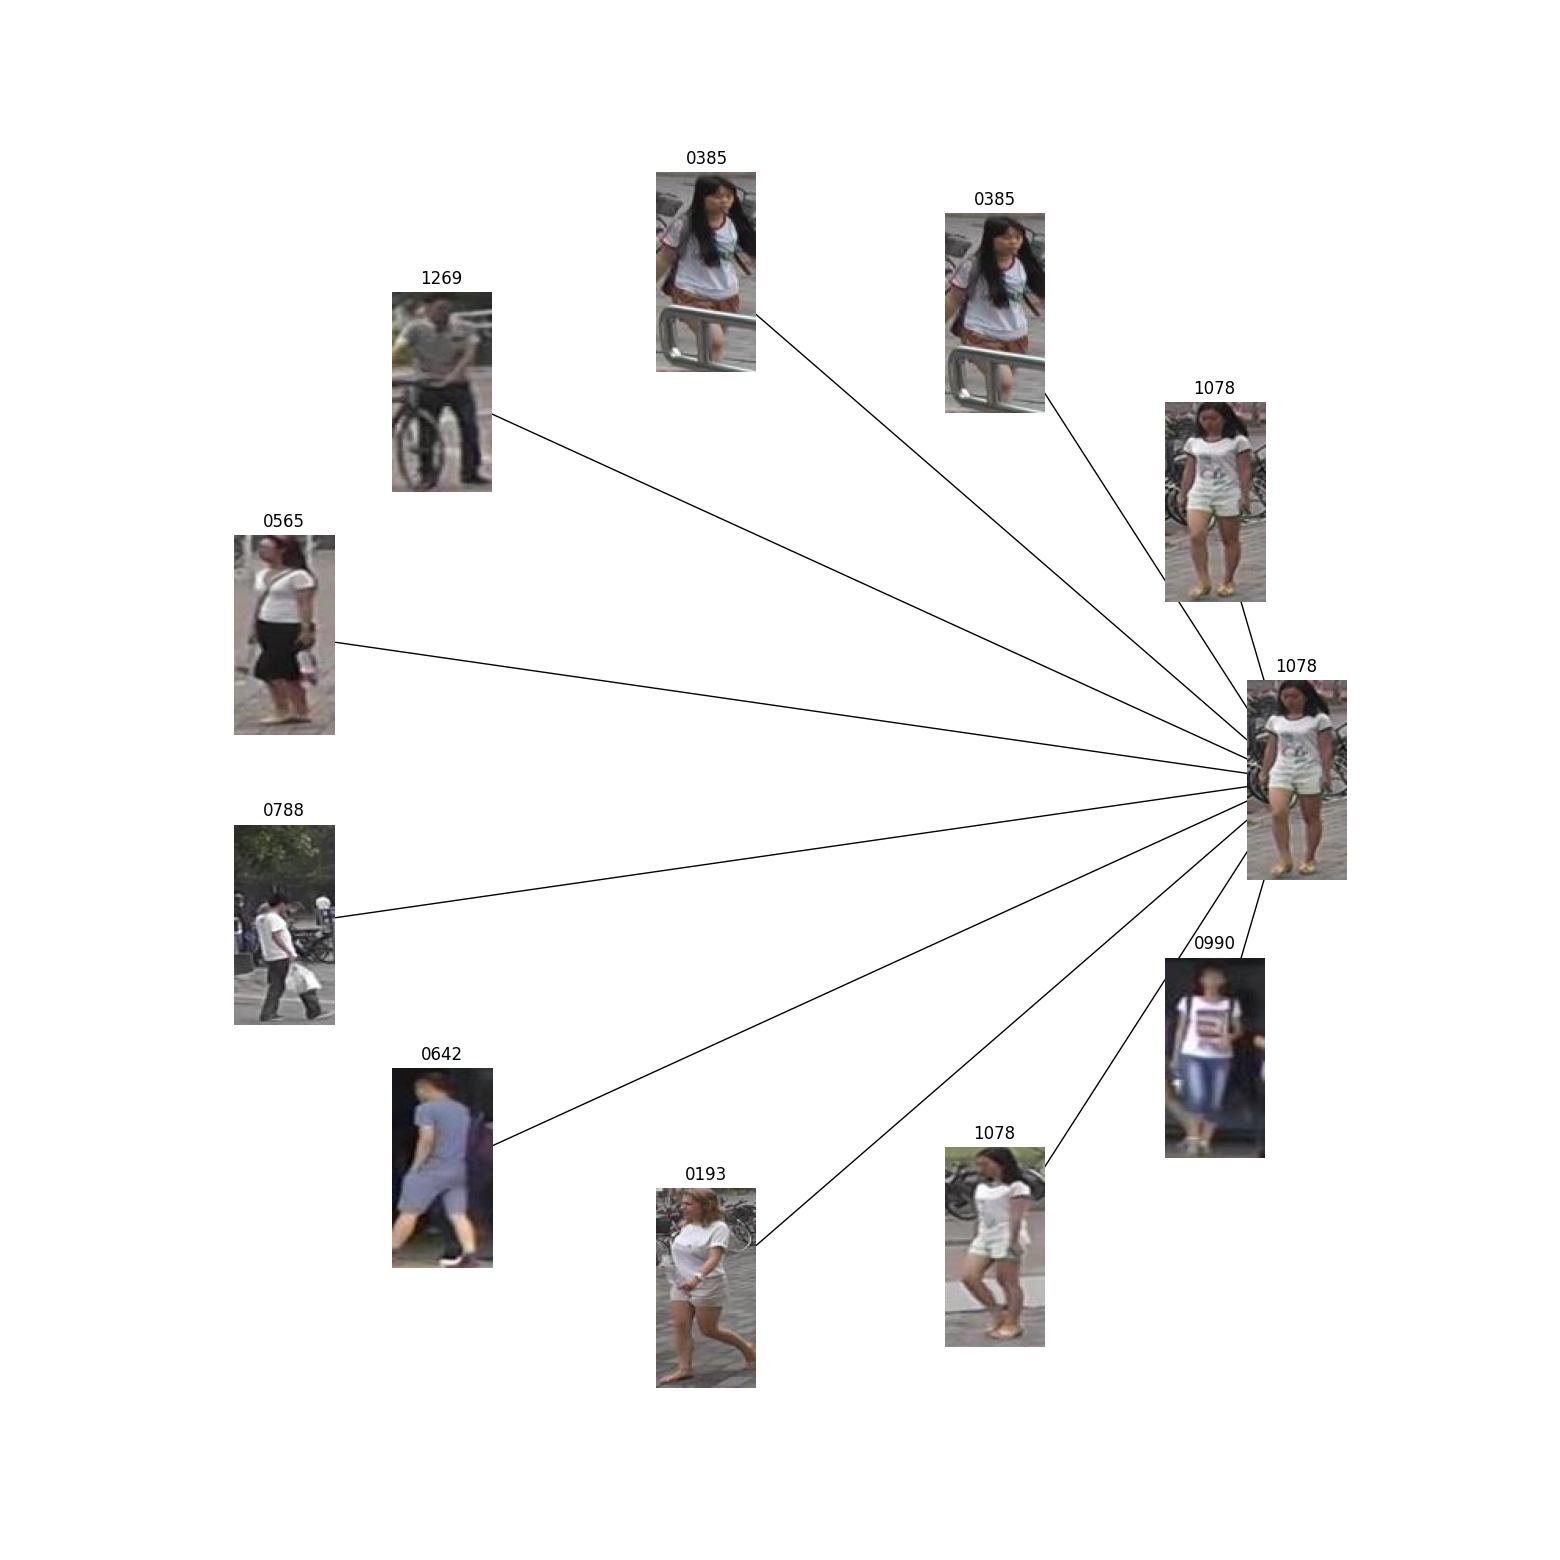

In [18]:
result = process_image(10, df_enc, model, data_dir)
anc_img_names, data_dir, img, img_path, closest_idx, distance = result

plot_closest_imgs(anc_img_names, data_dir, img_path, closest_idx, distance, no_of_closest=10)


In [20]:
import torch
from tqdm import tqdm

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Initialize counters for correct and total pairs
correct_pairs = 0
total_pairs = 0

model.eval()

with torch.no_grad():
    for A, P, N in tqdm(valid_loader):
        A, P, N = A.to(device), P.to(device), N.to(device)

        # Forward pass to get embeddings
        emb_A = model(A)
        emb_P = model(P)
        emb_N = model(N)

        # Compute Euclidean distances
        dist_pos = torch.norm(emb_A - emb_P, dim=1)
        dist_neg = torch.norm(emb_A - emb_N, dim=1)

        # Check if the distance of the positive pair is smaller than the distance of the negative pair
        correct_pairs += torch.sum(dist_pos < dist_neg).item()
        total_pairs += A.size(0)  # Batch size

# Calculate similarity accuracy
similarity_accuracy = correct_pairs / total_pairs

print(f"Similarity Accuracy: {similarity_accuracy * 100:.2f}%")


100%|██████████| 25/25 [00:01<00:00, 16.08it/s]

Similarity Accuracy: 95.38%


# ROC

In [21]:
model.load_state_dict(torch.load("best_model_triplet_10.pt"))
print("Model Loaded")

Model Loaded


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("model loaded")

model loaded


In [27]:
# Function to calculate similarity scores
def calculate_similarity(embedding1, embedding2):
    # Cosine similarity is a common choice
    return torch.nn.functional.cosine_similarity(embedding1, embedding2).cpu().numpy()


# Prepare data for ROC
similarity_scores = []
true_labels = []

with torch.no_grad():
    # for batch in valid_loader:
    for batch in train_loader:    
        anchor_images, positive_images, negative_images = batch  
        anchor_images, positive_images, negative_images = anchor_images.to(device), positive_images.to(device), negative_images.to(device)

        # Forward pass for anchor-positive pairs
        anchor_embeddings = model(anchor_images)
        positive_embeddings = model(positive_images)
        scores_positive = calculate_similarity(anchor_embeddings, positive_embeddings)
        similarity_scores.extend(scores_positive)
        true_labels.extend([1] * len(scores_positive))  # 1 for similar

        # Forward pass for anchor-negative pairs
        negative_embeddings = model(negative_images)
        scores_negative = calculate_similarity(anchor_embeddings, negative_embeddings)
        similarity_scores.extend(scores_negative)
        true_labels.extend([0] * len(scores_negative))  # 0 for not similar

In [28]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(true_labels, similarity_scores)
roc_auc = auc(fpr, tpr)

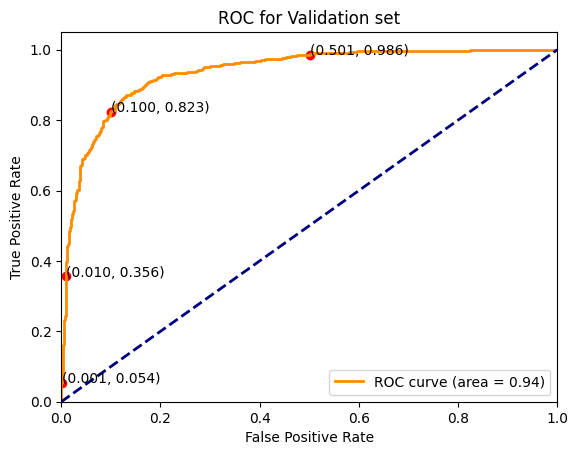

In [26]:
# Function to find closest index in an array to a given value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Desired FPR values
desired_fprs = [0.5, 0.1, 0.01, 0.001]

# Find nearest FPRs and corresponding TPRs
nearest_fprs = [fpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]
nearest_tprs = [tpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate desired points
for fpr_point, tpr_point in zip(nearest_fprs, nearest_tprs):
    plt.scatter(fpr_point, tpr_point, color='red')
    plt.text(fpr_point, tpr_point, f'({fpr_point:.3f}, {tpr_point:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Validation set')
plt.legend(loc="lower right")
plt.show()

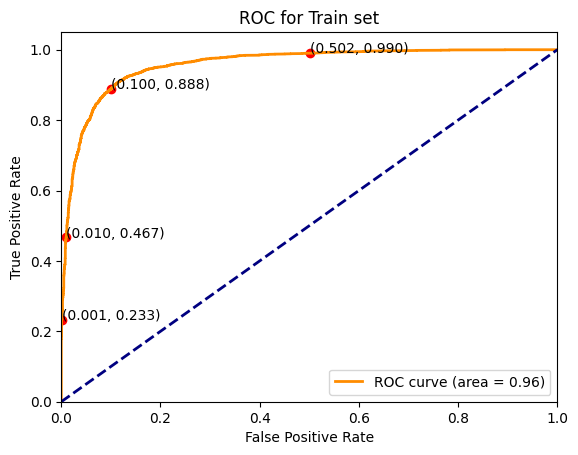

In [29]:
# Function to find closest index in an array to a given value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Desired FPR values
desired_fprs = [0.5, 0.1, 0.01, 0.001]

# Find nearest FPRs and corresponding TPRs
nearest_fprs = [fpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]
nearest_tprs = [tpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate desired points
for fpr_point, tpr_point in zip(nearest_fprs, nearest_tprs):
    plt.scatter(fpr_point, tpr_point, color='red')
    plt.text(fpr_point, tpr_point, f'({fpr_point:.3f}, {tpr_point:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Train set')
plt.legend(loc="lower right")
plt.show()